<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Ramki/E533_DLS_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install IPython
!pip install librosa
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 9.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.4 MB/s 


In [2]:
import numpy as np
from IPython.display import Audio
import librosa
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import backend as K
from librosa.core import stft,istft
from tensorflow.keras.layers import GRU,Dropout
from tensorflow.keras.layers import Conv1D,Conv2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import soundfile as sf
drive.mount('/content/drive/')

Mounted at /content/drive/


Q1: Data Augmentation

In [ ]:
cifar10 = tf.keras.datasets.cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
 X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
 print(X_train.shape)
 print(X_val.shape)
 print(Y_train.shape)
 print(Y_val.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(45000, 1)
(5000, 1)


In [ ]:
def normalize_tensor(tensor): 
    tensor = tf.math.divide(
          tf.subtract(
              tensor, 
              tf.reduce_min(tensor)
          ), 
          tf.subtract(
              tf.reduce_max(tensor), 
              tf.reduce_min(tensor)
          )
        )
    return 2*tensor-1

In [ ]:
X_train_n2, X_val_n2 = X_train/255.0, X_val/ 255.0

In [ ]:
Y_train, Y_val = Y_train.flatten(), Y_val.flatten()
layer = tf.keras.layers.Normalization(mean=0, variance=1)
X_train_n1 = normalize_tensor(X_train)
X_val_n1 = normalize_tensor(X_val)

In [ ]:
he_initializer = tf.keras.initializers.HeUniform(seed=None)

In [ ]:
model = tf.keras.Sequential()
model.add(Conv2D(10, (5, 5), strides=(1,1), activation='relu', input_shape=(32, 32, 3),kernel_initializer=he_initializer))
model.add(MaxPooling2D((2, 2),strides=(2,2)))
model.add(Conv2D(10, (5, 5), activation='relu',kernel_initializer=he_initializer))
model.add(MaxPooling2D((2, 2),strides=2))
model.add(Flatten())
model.add(Dense(units=20,activation='relu',kernel_initializer=he_initializer))
model.add(Dense(units=10,activation='softmax',kernel_initializer=he_initializer))

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
r = model.fit(X_train_n1, Y_train, validation_data=(X_val_n1, Y_val), batch_size=256, epochs=150)

Epoch 1/150
176/176 [==============================] - 2s 9ms/step - loss: 2.0114 - accuracy: 0.2582 - val_loss: 1.6965 - val_accuracy: 0.3752
Epoch 2/150
176/176 [==============================] - 1s 7ms/step - loss: 1.5875 - accuracy: 0.4270 - val_loss: 1.5260 - val_accuracy: 0.4444
Epoch 3/150
176/176 [==============================] - 1s 7ms/step - loss: 1.4446 - accuracy: 0.4827 - val_loss: 1.4128 - val_accuracy: 0.4954
Epoch 4/150
176/176 [==============================] - 1s 8ms/step - loss: 1.3785 - accuracy: 0.5065 - val_loss: 1.3608 - val_accuracy: 0.5102
Epoch 5/150
176/176 [==============================] - 1s 7ms/step - loss: 1.3321 - accuracy: 0.5268 - val_loss: 1.3296 - val_accuracy: 0.5196
Epoch 6/150
176/176 [==============================] - 1s 7ms/step - loss: 1.2956 - accuracy: 0.5390 - val_loss: 1.2860 - val_accuracy: 0.5420
Epoch 7/150
176/176 [==============================] - 1s 7ms/step - loss: 1.2660 - accuracy: 0.5519 - val_loss: 1.2636 - val_accuracy: 0.5502

In [ ]:
aug_x_train1 = np.minimum(1.1*X_train_n2, 1)
aug_x_train1 = normalize_tensor(aug_x_train1)
aug_x_train2 = 0.9*X_train_n2
aug_x_train2 = normalize_tensor(aug_x_train2)
aug_x_train3 = tf.image.flip_left_right(X_train_n2)
aug_x_train3 = normalize_tensor(aug_x_train3)
aug_x_train4 = X_train_n2
aug_x_train4 = normalize_tensor(aug_x_train4)

In [ ]:
X_train_aug = tf.concat([aug_x_train1,aug_x_train2,aug_x_train3,aug_x_train4],0)

In [ ]:
X_train_aug.shape

TensorShape([180000, 32, 32, 3])

In [ ]:
Y_train_aug = tf.concat([Y_train,Y_train,Y_train,Y_train],0)

In [ ]:
X_train_n1 = X_train_aug
X_val_n1 = normalize_tensor(X_val)

In [ ]:
model1 = tf.keras.Sequential()
model1.add(Conv2D(10, (5, 5), strides=(1,1), activation='relu', input_shape=(32, 32, 3),kernel_initializer=he_initializer))
model1.add(MaxPooling2D((2, 2),strides=(2,2)))
model1.add(Conv2D(10, (5, 5), activation='relu',kernel_initializer=he_initializer))
model1.add(MaxPooling2D((2, 2),strides=2))
model1.add(Flatten())
model1.add(Dense(units=20,activation='relu',kernel_initializer=he_initializer))
model1.add(Dense(units=10,activation='softmax',kernel_initializer=he_initializer))

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
r1 = model1.fit(X_train_n1, Y_train_aug, validation_data=(X_val_n1, Y_val), batch_size=512, epochs=150)

Epoch 1/150
352/352 [==============================] - 14s 14ms/step - loss: 1.7972 - accuracy: 0.3437 - val_loss: 1.4565 - val_accuracy: 0.4766
Epoch 2/150
352/352 [==============================] - 4s 13ms/step - loss: 1.3697 - accuracy: 0.5096 - val_loss: 1.3170 - val_accuracy: 0.5250
Epoch 3/150
352/352 [==============================] - 5s 13ms/step - loss: 1.2667 - accuracy: 0.5506 - val_loss: 1.2556 - val_accuracy: 0.5476
Epoch 4/150
352/352 [==============================] - 5s 14ms/step - loss: 1.2061 - accuracy: 0.5736 - val_loss: 1.2058 - val_accuracy: 0.5756
Epoch 5/150
352/352 [==============================] - 5s 14ms/step - loss: 1.1581 - accuracy: 0.5915 - val_loss: 1.1630 - val_accuracy: 0.5908
Epoch 6/150
352/352 [==============================] - 5s 14ms/step - loss: 1.1190 - accuracy: 0.6061 - val_loss: 1.1409 - val_accuracy: 0.5994
Epoch 7/150
352/352 [==============================] - 5s 14ms/step - loss: 1.0896 - accuracy: 0.6171 - val_loss: 1.1292 - val_accuracy

In [ ]:
val_acc1 = r.history['val_accuracy']
val_acc2 = r1.history['val_accuracy']

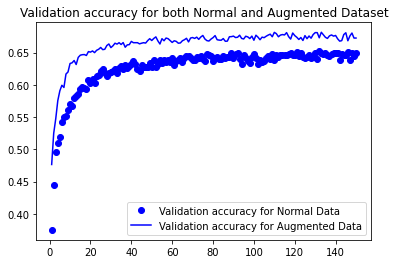

In [ ]:
epochs = range(1, 151)

plt.figure()
plt.plot(epochs, val_acc1, 'bo', label='Validation accuracy for Normal Data')
plt.plot(epochs, val_acc2, 'b', label='Validation accuracy for Augmented Data')
plt.title('Validation accuracy for both Normal and Augmented Dataset')
plt.legend()

plt.show()

Q2: Self-Supervised Learning via Pretext Tasks 

In [3]:
cifar10 = tf.keras.datasets.cifar10

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [5]:
labelled_X_train,unlabelled_X_train = x_train[49500:50000],x_train[0:49500]
labelled_Y_train,unlabelled_Y_train = y_train[49500:50000],y_train[0:49500]

In [6]:
labelled_X_train = tf.convert_to_tensor(labelled_X_train)
unlabelled_X_train = tf.convert_to_tensor(unlabelled_X_train)
labelled_Y_train = tf.convert_to_tensor(labelled_Y_train)
unlabelled_Y_train = tf.convert_to_tensor(unlabelled_Y_train)

In [7]:
print(labelled_X_train.shape)
print(unlabelled_X_train.shape)

(500, 32, 32, 3)
(49500, 32, 32, 3)


In [8]:
print(y_train[0:49500].shape)

(49500, 1)


In [9]:
Y_train0 = tf.zeros(shape = y_train[0:49500].shape,dtype=tf.int32)

In [10]:
X_train_upside_down = tf.image.flip_up_down(unlabelled_X_train)
Y_train1 = tf.ones(shape=y_train[0:49500].shape,dtype=tf.int32)
X_train_rotated_ccwise = tf.image.rot90(unlabelled_X_train)
Y_train2 = 2*tf.ones(shape=y_train[0:49500].shape,dtype=tf.int32)

In [11]:
X_train_aug = tf.concat([unlabelled_X_train,X_train_upside_down,X_train_rotated_ccwise],0)
Y_train_aug = tf.concat([Y_train0,Y_train1,Y_train2],0)

In [12]:
print(X_train_aug.shape)
print(Y_train_aug.shape)

(148500, 32, 32, 3)
(148500, 1)


In [13]:
he_initializer = tf.keras.initializers.HeUniform(seed=None)
def create_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(10, (5, 5), strides=(1,1), activation='relu', name='layer1',input_shape=(32, 32, 3),kernel_initializer=he_initializer))
    model.add(MaxPooling2D((2, 2),name='layer2',strides=(2,2)))
    model.add(Conv2D(10, (5, 5), activation='relu',name='layer3',kernel_initializer=he_initializer))
    model.add(MaxPooling2D((2, 2),name='layer4',strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=20,activation='relu',name='layer5',kernel_initializer=he_initializer))
    model.add(Dense(units=3,activation='softmax',name='naaa',kernel_initializer=he_initializer))
    return model

In [20]:
model = create_model()
cce = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam',
                loss=cce,
                metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(),tf.keras.metrics.SparseCategoricalAccuracy()])

In [21]:
checkpoint_path = "/content/drive/MyDrive/DLS_DATA/training/cp-{epoch:02d}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [22]:
batch_size = 256
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*batch_size,
                                                 verbose=1)

In [23]:
model.fit(X_train_aug, 
          Y_train_aug,  
          epochs=100,
          verbose=1,
          batch_size=batch_size,
          callbacks=[cp_callback])

Epoch 1/100
581/581 [==============================] - 3s 5ms/step - loss: 3.3179 - sparse_categorical_crossentropy: 3.3179 - sparse_categorical_accuracy: 0.3371
Epoch 2/100
581/581 [==============================] - 3s 5ms/step - loss: 1.1000 - sparse_categorical_crossentropy: 1.1000 - sparse_categorical_accuracy: 0.3321
Epoch 3/100
581/581 [==============================] - 4s 6ms/step - loss: 1.0990 - sparse_categorical_crossentropy: 1.0990 - sparse_categorical_accuracy: 0.3321
Epoch 4/100
581/581 [==============================] - 3s 5ms/step - loss: 1.0986 - sparse_categorical_crossentropy: 1.0986 - sparse_categorical_accuracy: 0.3323
Epoch 5/100
234/581 [===========>..................] - ETA: 1s - loss: 1.0982 - sparse_categorical_crossentropy: 1.0982 - sparse_categorical_accuracy: 0.3341
Epoch 5: saving model to /content/drive/MyDrive/DLS_DATA/training/cp-05.hdf5
581/581 [==============================] - 3s 5ms/step - loss: 1.0983 - sparse_categorical_crossentropy: 1.0983 - spa

In [24]:
os.listdir(checkpoint_dir)

['cp-05.hdf5',
 'cp-09.hdf5',
 'cp-14.hdf5',
 'cp-18.hdf5',
 'cp-23.hdf5',
 'cp-27.hdf5',
 'cp-31.hdf5',
 'cp-36.hdf5',
 'cp-40.hdf5',
 'cp-45.hdf5',
 'cp-49.hdf5',
 'cp-53.hdf5',
 'cp-58.hdf5',
 'cp-62.hdf5',
 'cp-67.hdf5',
 'cp-71.hdf5',
 'cp-75.hdf5',
 'cp-80.hdf5',
 'cp-84.hdf5',
 'cp-89.hdf5',
 'cp-93.hdf5',
 'cp-97.hdf5']

In [26]:
latest = '/content/drive/MyDrive/DLS_DATA/training/cp-97.hdf5'

In [27]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)

Baseline Model:

In [28]:
import sys
from contextlib import redirect_stdout

In [29]:
log_path = "text_file_name.txt"

class print_epochs(tf.keras.callbacks.Callback):
  def __init__(self,log_path):
      self.log_path = log_path
  def on_epoch_end(self, epoch, logs=None):
    with open(self.log_path, 'a') as writefile: # put log_path here
      with redirect_stdout(writefile):
        if(int(epoch) % 100) == 0:
          print("Epoch: {:>3} | Loss: ".format(epoch) + f"{logs['loss']:.4e}" + " | Valid loss: " + f"{logs['val_loss']:.4e}")
          writefile.write("\n")

In [30]:
he_initializer = tf.keras.initializers.HeUniform(seed=None)
model1 = tf.keras.Sequential()
model1.add(Conv2D(10, (5, 5), strides=(1,1), activation='relu', name='layer1',input_shape=(32, 32, 3),kernel_initializer=he_initializer))
model1.add(MaxPooling2D((2, 2),name='layer2',strides=(2,2)))
model1.add(Conv2D(10, (5, 5), activation='relu',name='layer3',kernel_initializer=he_initializer))
model1.add(MaxPooling2D((2, 2),name='layer4',strides=(2,2)))
model1.add(Flatten())
model1.add(Dense(units=20,activation='relu',name='layer5',kernel_initializer=he_initializer))
model1.add(Dense(units=10,activation='softmax',name='naaa',kernel_initializer=he_initializer))
cce = tf.keras.losses.SparseCategoricalCrossentropy()
model1.compile(optimizer='adam',
                loss=cce,
                metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(),tf.keras.metrics.SparseCategoricalAccuracy()])

In [31]:
p_e = print_epochs(log_path)
batch_size = 256
history1 = model1.fit(labelled_X_train, 
          labelled_Y_train,  
          epochs=10000,
          validation_data = (x_test, y_test),
          verbose=1,
          batch_size=batch_size,
          callbacks=[p_e])

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 186ms/step - loss: 1.3738 - sparse_categorical_crossentropy: 1.3738 - sparse_categorical_accuracy: 0.4880 - val_loss: 17.9434 - val_sparse_categorical_crossentropy: 17.9434 - val_sparse_categorical_accuracy: 0.1630
Epoch 7502/10000
2/2 [==============================] - 0s 338ms/step - loss: 1.3709 - sparse_categorical_crossentropy: 1.3709 - sparse_categorical_accuracy: 0.4880 - val_loss: 18.0755 - val_sparse_categorical_crossentropy: 18.0755 - val_sparse_categorical_accuracy: 0.1631
Epoch 7503/10000
2/2 [==============================] - 0s 336ms/step - loss: 1.3702 - sparse_categorical_crossentropy: 1.3702 - sparse_categorical_accuracy: 0.4880 - val_loss: 18.1235 - val_sparse_categorical_crossentropy: 18.1235 - val_sparse_categorical_accuracy: 0.1639
Epoch 7504/10000
2/2 [==============================] - 0s 186ms/step - loss: 1.3691 - sparse_categorical_crossentropy: 1.3691 - sparse_categori

In [32]:
model = tf.keras.Sequential()
model.add(Conv2D(10, (5, 5), strides=(1,1), activation='relu', name='layer1',input_shape=(32, 32, 3),kernel_initializer=he_initializer))
model.add(MaxPooling2D((2, 2),name='layer2',strides=(2,2)))
model.add(Conv2D(10, (5, 5), activation='relu',name='layer3',kernel_initializer=he_initializer))
model.add(MaxPooling2D((2, 2),name='layer4',strides=2))
model.add(Flatten())
model.add(Dense(units=20,activation='relu',name='layer5',kernel_initializer=he_initializer))

In [33]:
model.load_weights(latest,by_name=True)
model.add(Dense(units=10,activation='softmax',name='tata',kernel_initializer=he_initializer)) 

In [34]:
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-5),
    tf.keras.optimizers.Adam(learning_rate=1e-3)
]
optimizers_and_layers = [(optimizers[0], model.layers[:-1]), (optimizers[1], model.layers[-1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
cce = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,
                loss=cce,
                metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])

In [35]:
p_e = print_epochs(log_path)
batch_size = 256
history2 = model1.fit(labelled_X_train, 
          labelled_Y_train,  
          epochs=10000,
          validation_data = (x_test, y_test),
          verbose=2,
          batch_size=batch_size,
          callbacks=[p_e])

Streaming output truncated to the last 5000 lines.
Epoch 7501/10000
2/2 - 0s - loss: 0.9391 - sparse_categorical_crossentropy: 0.9391 - sparse_categorical_accuracy: 0.6720 - val_loss: 70.8242 - val_sparse_categorical_crossentropy: 70.8242 - val_sparse_categorical_accuracy: 0.1961 - 177ms/epoch - 88ms/step
Epoch 7502/10000
2/2 - 0s - loss: 0.9380 - sparse_categorical_crossentropy: 0.9380 - sparse_categorical_accuracy: 0.6720 - val_loss: 70.3657 - val_sparse_categorical_crossentropy: 70.3657 - val_sparse_categorical_accuracy: 0.1947 - 181ms/epoch - 91ms/step
Epoch 7503/10000
2/2 - 0s - loss: 0.9370 - sparse_categorical_crossentropy: 0.9370 - sparse_categorical_accuracy: 0.6720 - val_loss: 70.0070 - val_sparse_categorical_crossentropy: 70.0070 - val_sparse_categorical_accuracy: 0.1942 - 177ms/epoch - 89ms/step
Epoch 7504/10000
2/2 - 0s - loss: 0.9360 - sparse_categorical_crossentropy: 0.9360 - sparse_categorical_accuracy: 0.6720 - val_loss: 69.7255 - val_sparse_categorical_crossentropy: 6

In [ ]:
val_acc1 = history1.history['val_sparse_categorical_accuracy']
val_acc2 = history2.history['val_sparse_categorical_accuracy']

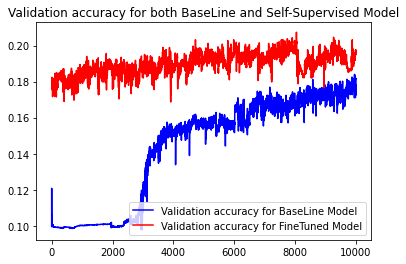

In [44]:
epochs = range(1, 10001)

plt.figure()
plt.plot(epochs, val_acc1, 'b-', label='Validation accuracy for BaseLine Model')
plt.plot(epochs, val_acc2, 'r-', label='Validation accuracy for FineTuned Model')
plt.title('Validation accuracy for both BaseLine and Self-Supervised Model')
plt.legend()

plt.show()

Q3: Speech Denoising Using RNN

In [ ]:
# !unzip '/content/drive/MyDrive/DLS_DATA/homework3.zip' -d '/content/drive/MyDrive/DLS_DATA/timit-hw3'

In [ ]:
path = '/content/drive/MyDrive/DLS_DATA/timit-hw3/timit-homework/tr'

X = []
S = []
N = []

for f in os.listdir(path):
    if(os.path.isfile(os.path.join(path,f))):
        if(f[:3]=='trn'):
          s, sr = librosa.load(os.path.join(path,f),sr=None)
          trn_stft=librosa.stft(s, n_fft=1024, hop_length=512)
          N.append(abs(trn_stft))
        elif(f[:3]=='trs'):
          s, sr = librosa.load(os.path.join(path,f),sr=None)
          trs_stft=librosa.stft(s, n_fft=1024, hop_length=512)
          S.append(abs(trs_stft))
        else:
          s, sr = librosa.load(os.path.join(path,f),sr=None)
          trx_stft=librosa.stft(s, n_fft=1024, hop_length=512)
          X.append(abs(trx_stft))

In [ ]:
print(N[-1].shape)
print(S[-1].shape)
print(X[-1].shape)

In [ ]:
max_len = X[0].shape[1]
for k in range(1,len(X)):
    if(X[k].shape[1]>max_len):
        max_len = X[k].shape[1]
print(max_len)

In [ ]:
M_arr = []
for i in range(len(N)):
    # print("Before:",S[i].shape,N[i].shape)
    if(S[i].shape[1]<N[i].shape[1]):
        S[i] = np.pad(S[i],((0,0),(0,N[i].shape[1]-S[i].shape[1])),mode='constant')
    elif(S[i].shape[1]>N[i].shape[1]):
        N[i] = np.pad(N[i],((0,0),(0,S[i].shape[1]-N[i].shape[1])),mode='constant')
    # print("After:",S[i].shape,N[i].shape)
    M = np.where((S[i]>N[i]),1,0)
    M_arr.append(M)

In [ ]:
for i in range(len(X)):
    X[i] = np.pad(X[i],((0,0),(0,max_len-X[i].shape[1])),mode='constant')
    X[i] = X[i].T
    M_arr[i] = np.pad(M_arr[i],((0,0),(0,max_len-M_arr[i].shape[1])),mode='constant')
    M_arr[i] = M_arr[i].T

In [ ]:
print(M_arr[0].shape)
print(M_arr[1].shape)
print(M_arr[2].shape)
print(M_arr[3].shape)

In [ ]:
X = np.dstack(X)
X = np.rollaxis(X,-1)
M_arr = np.dstack(M_arr)
M_arr = np.rollaxis(M_arr,-1)
print(X.shape)
print(M_arr.shape)

In [ ]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
M_arr = tf.convert_to_tensor(M_arr, dtype=tf.float32)
print(X.shape)
print(M_arr.shape)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(max_len,513),batch_size=10))
model.add(tf.keras.layers.GRU(513, return_sequences=True, input_shape =(max_len,513), dropout=0.3))
model.add(tf.keras.layers.GRU(513, return_sequences=True, dropout=0.3))
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=513,activation='relu'))
model.compile(optimizer='adam',loss = 'mean_squared_error')

In [ ]:
model.summary()

In [ ]:
model.fit(X,M_arr,batch_size=10,epochs=100)